# A/B Testing

## Background reading:
*Intro to Statistical Learning*: Chapter 13, Mutiple Testing (Sections 13.1 and 13.2, Page 553-561)

*Ethical Algorithm*: Chapter 3, Game People Play, The Commuting Game, (Page 101-105)

*Ethical Algorithm*: Chapter 4, Lost in the Garden, Past Performance is No Guarantee of Future Returns, (Page 137-141)

## Dataset:
The example from github uses the ecommerce testing dataset from kaggle
Link: https://www.kaggle.com/zhangluyuan/ab-testing 

Attribute columns:
1. ID - unique user ID
2. Time - what time the advertisement was shown to the user
3. Con_Treat - whether the user is in the control or treatment group
4. Page - whether the user can see the old or new page
5. Converted - did the user click on the add (Yes = 1) or (No = 0)

In this case A is column 5, whether the user clicked on the ad or not
B is columns 3 and 4 which is whether the user is a member of the control group (old page) or treatment group (new page)

**Article:** https://hbr.org/2017/06/a-refresher-on-ab-testing 


## Essence of Data:

### What is A/B Testing?

![](../../../fig/ABTest/fig1.png)


It is a way to compare multiple versions of a feature to see which performs better. It is typically used for websites

Example: If the advertisement is bigger, will more people click on it? Are users more likely to purchase from a website with a different user interface?

Example Application: Google doing A/B Testing with different shades of blue for link colors
https://bharathbalasubramanian.medium.com/data-driven-decisions-googles-50-shades-of-blue-experiment-996f01819a97 

Another Example Application: Harvard Business School: “Is A/B Testing Effective? Evidence from 35,000 Startups”
https://hbswk.hbs.edu/item/is-ab-testing-effective-evidence-from-35000-startups 

It is the most basic type of a randomized controlled experiment. It is a statistical test and the number of samples (n) needed to determine statistical significance should be determined before the experiment is done. A null and alternative hypothesis must be determined then a statistical test needs to be performed to determine whether the results between the two groups are statistically significant.

![](../../../fig/ABTest/fig2.png)


An A/B test can be tied to multi-armed bandits because the algorithm will use the differences between the two responses to determine if an option should be exploited or explored.

With A/B testing of a graphic e-commerce website advertisement (like our python tutorial) exploitation would mean using the advertisement that is more likely to be clicked on as the “winner” and using this advertisement to drive clicks to the companies’ website. Exploration could mean getting more data on the advertisement that seems “least effective”. For example, continuing user testing to see if the less popular advertisement is more effective with certain user demographics compared to the “winner”. 


### Example Code

In [1]:
import pandas as pd
import math
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
#Load the dataset and columns of interest
clickdataset = '../../../data/ab_test.csv'
df = pd.read_csv(clickdataset)
#, usecols = ['id','con_treat','page','converted']

In [3]:
#checking both datasets for null values
df.isna().sum()

id           0
time         0
con_treat    0
page         0
converted    0
dtype: int64

In [4]:
df.describe()

,id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [5]:
#show the head of the dataset

df.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [6]:
#identify rows where the treatment doesn't match new page and the control doesn't match the old page
df.query('page == "new_page" & con_treat != "treatment"').count()[0] + df.query('page == "old_page" & con_treat != "control"').count()[0]

3893

In [7]:
#split data into into a new dataframe where the page and treatment match
dfnew = df.query('page == "new_page" & con_treat == "treatment" | page == "old_page" & con_treat == "control"')

In [8]:
#remove any duplicate userids
dfnew = dfnew.drop_duplicates(subset = 'id',keep = "first")

In [9]:
#check the number of unique users that clicked on the ad (both new and old versions of the page)
converted_all = sum(dfnew.query('converted == 1').converted)/len(dfnew['id'])
print('The proportion of users that click on either version of the advertisement is {0}'.format(converted_all))

The proportion of users that click on either version of the advertisement is 0.11959708724499628


In [10]:
#find the click rate for users shown the old version of the ad (control group)
converted_control = len(dfnew.query('converted == 1 & con_treat == "control"')['id'])/len(dfnew.query('con_treat == "control"')['id'])
print('The proportion of users from the control group that click on the old advertisement is {0}'.format(converted_control))

The proportion of users from the control group that click on the old advertisement is 0.1203863045004612


In [11]:
#find the click rate for users shown the new version of the ad (treatment group)
converted_treatment = len(dfnew.query('converted == 1 & con_treat == "treatment"')['id'])/len(dfnew.query('con_treat == "treatment"')['id'])
print('The proportion of users from the treatment group that click on the new advertisement is {0}'.format(converted_treatment))

The proportion of users from the treatment group that click on the new advertisement is 0.11880806551510564


In [12]:
converted_difference = converted_control - converted_treatment

print('The difference between the proportion of the control group and treatment group that click on the ad is {0}'.format(converted_difference))

The difference between the proportion of the control group and treatment group that click on the ad is 0.0015782389853555567


In [13]:
#Test for statistical significance using z test and 95% confidence interval
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['con_treat'] == 'control']['converted']
treatment_results = df[df['con_treat'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs = nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.24
p-value: 0.216
95% confidence interval for control group: [0.119, 0.122]
95% confidence interval for treatment group: [0.117, 0.121]


In [14]:
print('The p-value is {0} which is greater than 0.05 so we fail to reject the null hypothesis and conclude that the difference between the groups is not statistically significant'.format(pval))

The p-value is 0.21611613269757501 which is greater than 0.05 so we fail to reject the null hypothesis and conclude that the difference between the groups is not statistically significant


In [15]:
#extract the first two digits of each time value
df['time']=df['time'].str[0:2].astype(int)
df.head()

,id,time,con_treat,page,converted
0,851104,11,control,old_page,0
1,804228,1,control,old_page,0
2,661590,55,treatment,new_page,0
3,853541,28,treatment,new_page,0
4,864975,52,control,old_page,1


NameError: name 'ax' is not defined

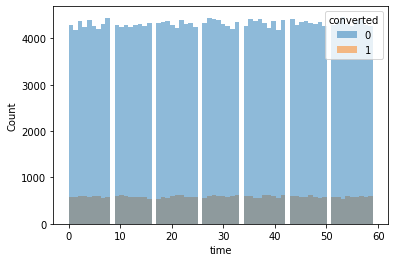

In [16]:
#plot the converted vs non-converted users over time in a histogram
sns.histplot(data=df, x='time', hue = 'converted', edgecolor=None)
ax.set_title ('Converted vs Nonconverted Over Time')

In [ ]:
#Based on the histogram, there is no difference in the number of converted vs non-converted users over time.

## AI in fabrics of society:
Similar to the advertisement allocation that the company aims at increasing the click rate of the user so that users can receive information about the goods that they like, the business companies always devote themselves to providing a convenient experience to their customers.In real cases, companies have to make decisions like this to win the rivalry. They find the best strategy to give them more revenue in such a game.

One interesting topic is the recommendation of the commuting routes suggested by the map software. The software has to determine the best path for its users so that they feel convenient and will continue to use it. Sometimes, the shortest path is not the optimum because of the traffic. 

Reading: *Ethical Algorithm*: Chapter 3, Game People Play, The Commuting Game, (Page 101-105)

### More on A/B testing and ethis of experimentation  in tech:

Rajkumar, Karthik, et al. "A causal test of the strength of weak ties." Science 377.6612 (2022): 1304-1310. https://www.science.org/doi/10.1126/science.abl4476

Experts debate the ethics of LinkedIn's algorithm experiments on 20M users
Ars Technica | 09/26/2022: https://arstechnica.com/tech-policy/2022/09/experts-debate-the-ethics-of-linkedins-algorithm-experiments-on-20m-users/

LinkedIn ran social experiments on 20 million users over five years
The New York Times | 09/24/2022: https://www.nytimes.com/2022/09/24/business/linkedin-social-experiments.html

Building inclusive products through A/B testing: https://engineering.linkedin.com/blog/2020/building-inclusive-products-through-a-b-testing?s=31